In [50]:
from transformers import pipeline
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
import random
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity

In [51]:
#model = AutoModel.from_pretrained( "gpt2", output_hidden_states=True)  #load pretrained from Hugging Face
model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")                     #trasforma input in token

model.eval()    # Set to evaluation mode: Turns off dropout, ensuring deterministic outputs; Freezes running statistics (in LayerNorm).

c:\Users\angel\Desktop\LCP_B_GPT2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
c:\Users\angel\Desktop\LCP_B_GPT2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [52]:
prompts = {
    "short": [
        "Sunset",
        "The quick fox",
        "Hello world",
        "Once upon a",
        "Artificial intelligence"
    ],
    "medium": [
        "The cat sat on the warm windowsill and purred quietly.",
        "He opened the door to find a mysterious package waiting.",
        "Deep learning has revolutionized computer vision and natural language processing.",
        "A sudden noise startled her while she was reading a book.",
        "The recipe called for eggs, flour, sugar, and a pinch of salt."
    ],
    "long": [
        "The scientist carefully adjusted the settings on the control panel, knowing that one wrong move could trigger a catastrophic failure that would destroy years of research and potentially endanger lives.",
        "In a future where machines have gained consciousness, a lone programmer works tirelessly to insert a backdoor into the system, hoping to reclaim control of a world slipping away.",
        "During the final debate, the candidate made a passionate appeal to unity, addressing both critics and supporters, promising transparency, economic reform, and a renewed focus on international cooperation."
    ],
    "very_long": [
        "As the storm raged outside, Maria sat by the fireplace, recalling the last letter her brother had sent before disappearing in the mountains. It spoke of a hidden temple, an ancient curse, and a secret he had vowed to protect at all costs. Her hands trembled as she read it again.",
        "“I never asked for this,” he whispered, staring at the broken mask in his hands. Around him, the ruins of the facility burned, casting eerie shadows on the bloodstained walls. Footsteps echoed in the corridor—someone was still alive. And they were looking for him."
    ],
    "closed": [
    "Water freezes at 0 degrees",
    "The author of Romeo and Juliet is", 
    "Einstein is best known for the theory of",
    "Brazil's official language is",
    "Jupiter is the largest",
    "Gold’s chemical symbol is",
    "Opposite in meaning to 'hot' is",
    "Where is the Great Wall located?",
    "Tokyo is the capital of",
    "A triangle has how many sides?",
    "The boiling point of water in Celsius is",
    "Who painted the Mona Lisa?",
    "Pi is approximately equal to",
    "Mount Everest is located in which country?",
    "The organ responsible for pumping blood throughout the body is the"
    ]
}

target_answers = {
    "Water freezes at 0 degrees": "Celsius",
    "The author of Romeo and Juliet is": "Shakespeare",
    "Einstein is best known for the theory of": "relativity",
    "Brazil's official language is": "Portuguese",
    "Jupiter is the largest": "planet",
    "Gold’s chemical symbol is": "Au",
    "Opposite in meaning to 'hot' is": "cold",
    "Where is the Great Wall located?": "China",
    "Tokyo is the capital of": "Japan",
    "A triangle has how many sides?": "3",
    "The boiling point of water in Celsius is": "100",
    "Who painted the Mona Lisa?": "Leonardo",
    "Pi is approximately equal to": "3.14",
    "Mount Everest is located in which country?": "Nepal",
    "The organ responsible for pumping blood throughout the body is the" : "heart"
}

# TO USE:
# for category, prompt_list in prompts.items():
#    for prompt in prompt_list:
#        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
#        outputs = model(**inputs)
#        # your embedding analysis here...


## Testing the prediction on next token

With a set of closed prompts each designed to have a specific, factual answer

In [53]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [54]:
prompt = prompts["closed"][-1]
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print("Tokens:")
for idx, tok in enumerate(tokens):
    print(f"{idx:2}: {tok}")

# Containers for layer outputs
embedding_outputs = []
attention_outputs = []
mlp_outputs = []
ln1_outputs = []
ln2_outputs = []

# Hook functions to capture intermediate activations
def get_embedding_output(module, input, output):
    embedding_outputs.append(output.detach())

def get_attention_output(module, input, output):
    attention_outputs.append(output[0].detach())

def get_mlp_output(module, input, output):
    mlp_outputs.append(output.detach())

def get_ln1_output(module, input, output):
    ln1_outputs.append(output.detach())

def get_ln2_output(module, input, output):
    ln2_outputs.append(output.detach())


# Register forward hooks
model.transformer.drop.register_forward_hook(get_embedding_output)
#model.transformer.wpe.register_forward_hook(get_embedding_output)

for block in model.transformer.h:
    block.ln_1.register_forward_hook(get_ln1_output)
    block.attn.register_forward_hook(get_attention_output)
    block.ln_2.register_forward_hook(get_ln2_output)
    block.mlp.register_forward_hook(get_mlp_output)

model.transformer.ln_f.register_forward_hook(get_ln1_output)

Tokens:
 0: The
 1: Ġorgan
 2: Ġresponsible
 3: Ġfor
 4: Ġpumping
 5: Ġblood
 6: Ġthroughout
 7: Ġthe
 8: Ġbody
 9: Ġis
10: Ġthe


In [55]:
# Clear stored outputs before a new forward pass
embedding_outputs.clear()
attention_outputs.clear()
mlp_outputs.clear()
ln1_outputs.clear()
ln2_outputs.clear()

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits  # Shape: [1, seq_len, vocab_size]
attentions = outputs.attentions  # List of [1, n_heads, seq_len, seq_len]


## See most probable next token, entropy and attention at each layer

Prompt: The organ responsible for pumping blood throughout the body is the

[Attention] Layer  0: Last Token Entropy 6.8459, Mean Entropy 3.2809
   1:       Ġthe (0.1271)
   2:         Ġ" (0.0883)
   3:     Ġother (0.0515)
   4:      Ġmore (0.0307)
   5:      Ġsame (0.0283)
   6:      Ġvery (0.0258)
   7:     Ġfirst (0.0247)
   8:       Ġnew (0.0228)
   9:         Ġ' (0.0222)
  10:         Ġa (0.0221)
[Attention] Layer  1: Last Token Entropy 14.4746, Mean Entropy 13.4504
   1:  iferation (0.0034)
   2:    annabin (0.0029)
   3: ItemTracker (0.0021)
   4:       ļéĨĴ (0.0018)
   5: ĠguiActiveUn (0.0014)
   6:     Ġfixme (0.0013)
   7:   ĠCanaver (0.0013)
   8:  ĠRohingya (0.0012)
   9:        ©¶æ (0.0011)
  10:       ptin (0.0011)
[Attention] Layer  2: Last Token Entropy 14.9946, Mean Entropy 14.8025
   1:    ĠIchigo (0.0010)
   2:     ĠEater (0.0006)
   3:      ogene (0.0006)
   4:     Ġcondu (0.0006)
   5:     isible (0.0005)
   6:   imentary (0.0005)
   7:    athered (0.0005)
   8: Ġi

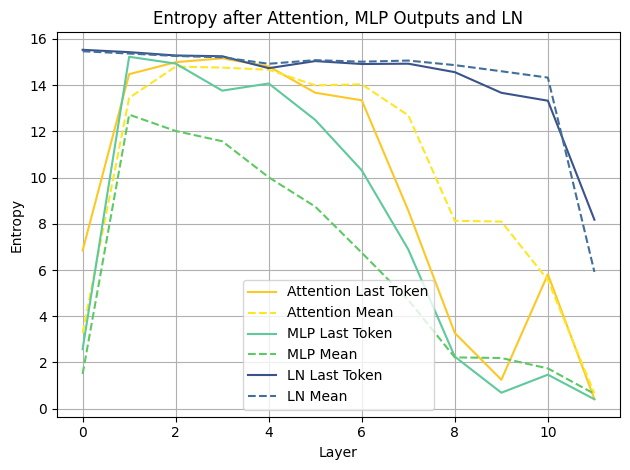

In [56]:
# Language modeling head
lm_head = model.lm_head  # Linear layer from hidden dim -> vocab size
top_k = 10  # Change as needed
token_position = -1  # Last token in prompt

print(f"Prompt: {prompt}\n")

temperature = 1.0  # Try 0.7 for sharper, or 1.5 for more diverse

def compute_entropy_from_outputs(outputs_list, label):
    entropy_last = []
    entropy_mean = []
    for i, layer_output in enumerate(outputs_list):
        hidden = layer_output  # shape: [1, seq_len, hidden_dim]
        last_token_vec = hidden[0, token_position, :]  # [hidden_dim]
        logits = lm_head(last_token_vec)
        scaled_logits = logits / temperature
        probs = torch.softmax(scaled_logits, dim=-1)
        top_probs, top_ids = torch.topk(probs, top_k)
        top_tokens = tokenizer.convert_ids_to_tokens(top_ids)
        
        entropy = -torch.sum(probs * torch.log2(probs + 1e-12)).item()
        entropy_last.append(entropy)

        all_logits = lm_head(hidden[0])  # shape: [seq_len, vocab_size]
        all_scaled_logits = all_logits / temperature
        all_probs = torch.softmax(all_scaled_logits, dim=-1)
        all_entropy = -torch.sum(all_probs * torch.log2(all_probs + 1e-12)).item()
        mean_entropy = all_entropy / all_probs.size(0)
        entropy_mean.append(mean_entropy)

        print(f"[{label}] Layer {i:2d}: Last Token Entropy {entropy:.4f}, Mean Entropy {mean_entropy:.4f}")
        for j in range(top_k):
            print(f"  {j+1:2d}: {top_tokens[j]:>10} ({top_probs[j].item():.4f})")

    
    return entropy_last, entropy_mean

# Compute for attention and MLP outputs
attn_entropy_last, attn_entropy_mean = compute_entropy_from_outputs(attention_outputs, "Attention")
mlp_entropy_last, mlp_entropy_mean = compute_entropy_from_outputs(mlp_outputs, "MLP")
ln_entropy_last, ln_entropy_mean = compute_entropy_from_outputs(ln1_outputs, "LN")

# Plotting
plt.plot(attn_entropy_last, label="Attention Last Token", c= "#fdc725")
plt.plot(attn_entropy_mean,"--", label="Attention Mean", c='#fde725')
plt.plot(mlp_entropy_last, label="MLP Last Token", c="#5ec99b")
plt.plot(mlp_entropy_mean,"--", label="MLP Mean", c='#5ec962')
plt.plot(ln_entropy_last[1:], label="LN Last Token", c='#3b528b')
plt.plot(ln_entropy_mean[1:],"--", label="LN Mean", c="#426f9a")
plt.xlabel("Layer")
plt.ylabel("Entropy")
plt.title("Entropy after Attention, MLP Outputs and LN")
plt.legend(loc='lower center')
plt.grid(True)
plt.tight_layout()
plt.show()


To analyze the dynamics of hidden states across layers, you're essentially exploring how the internal token representations evolve at each layer of the transformer. Here are several ways you can analyze and visualize these dynamics effectively:

1. Cosine Similarity Between Contiguous Layers -> ROTATIONS OF TOKENS DURING TRANSFORMATION

Measure how the hidden representation of a specific token (e.g., the last token "William") changes across layers.
Cosine similarity is a measure of similarity between two vectors based on the angle between them—not their length. It's commonly used in natural language processing (NLP) to compare how "similar" two token embeddings or hidden states are.

Formula:
For two vectors A and B, the cosine similarity is:

cosine_similarity(𝐴,𝐵)=𝐴⋅𝐵/(∥𝐴∥∥𝐵∥)

1.0 → Vectors point in the same direction → Very similar

0.0 → Vectors are orthogonal (90° apart) → No similarity

–1.0 → Vectors point in opposite directions → Completely dissimilar
​

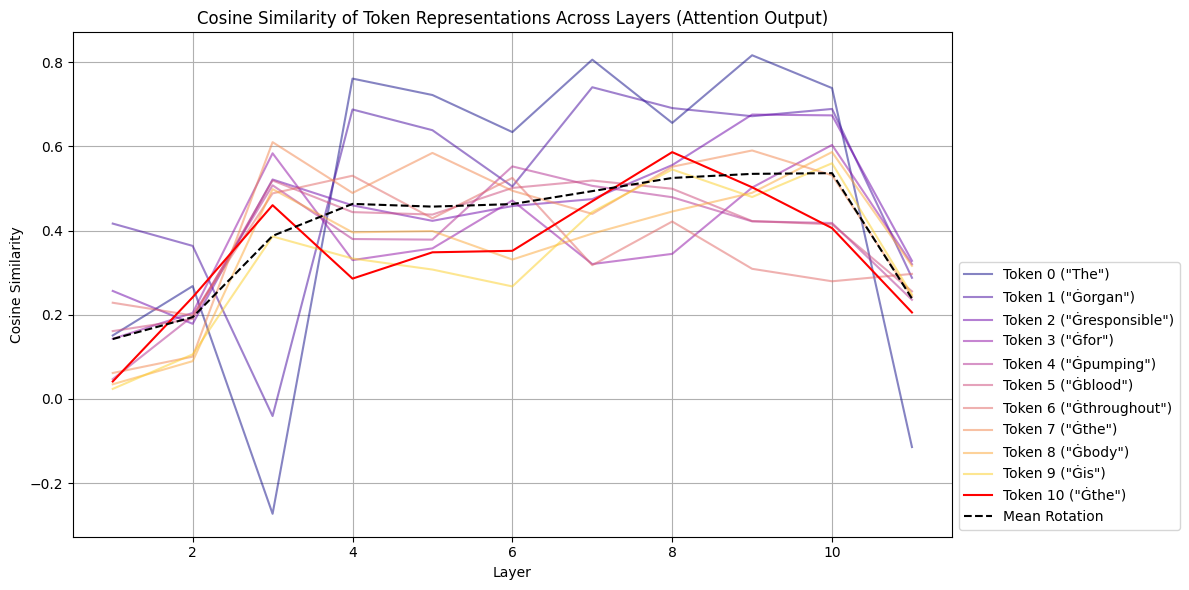

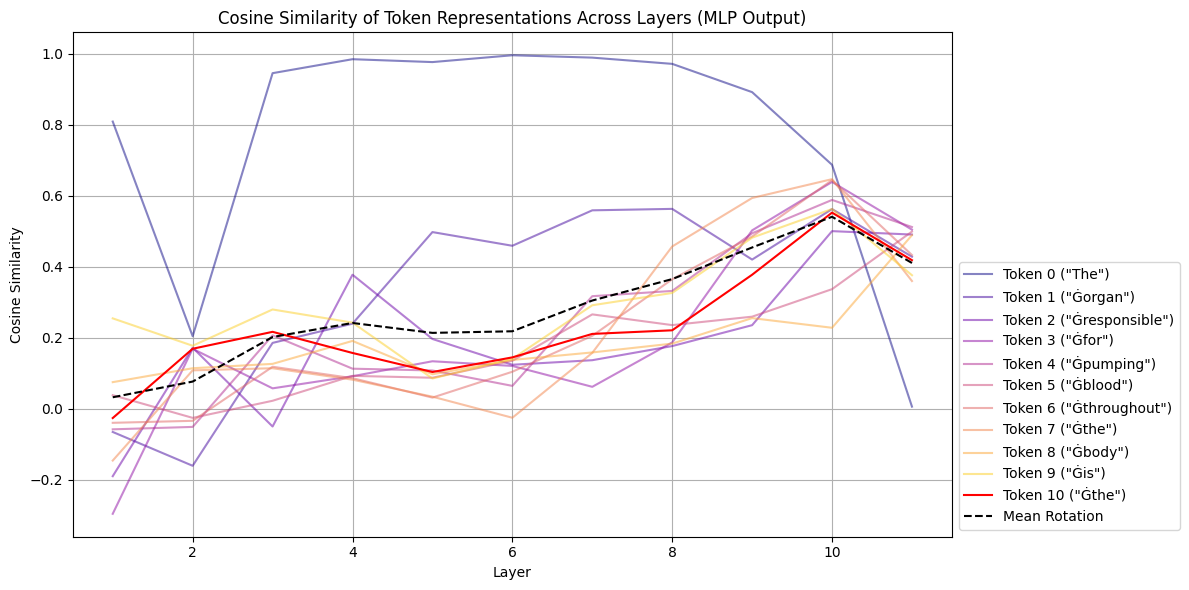

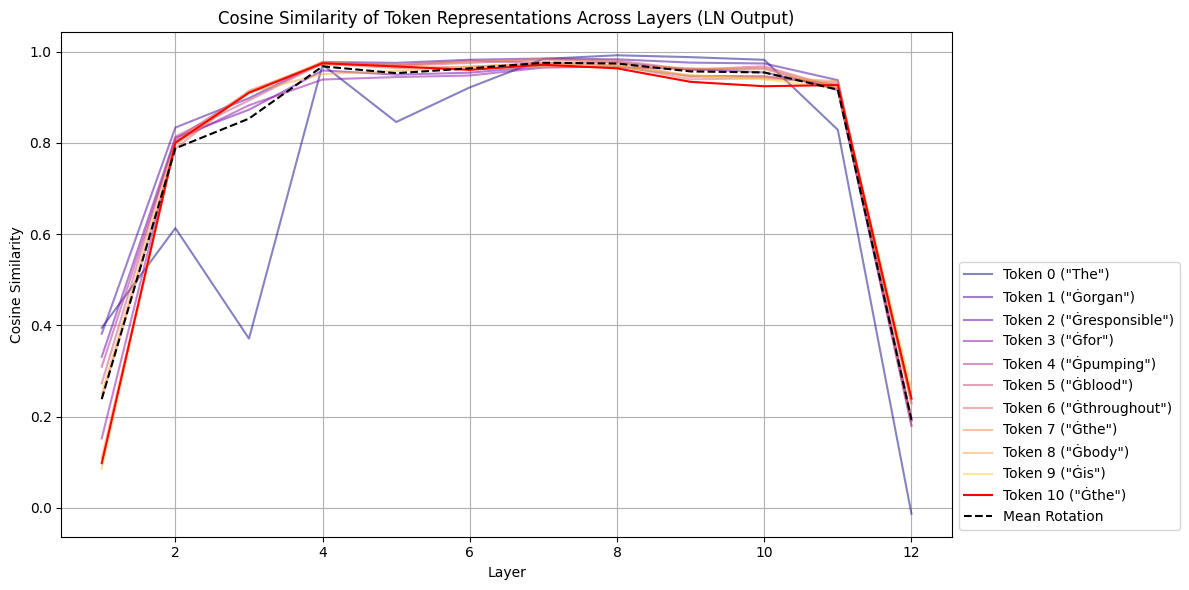

In [57]:
def compute_cosine_rotations(outputs_list, tokens, label):
    seq_len = outputs_list[0].shape[1]  # sequence length
    n_layers = len(outputs_list)
    
    all_token_rotations = []
    for pos in range(seq_len):
        vectors = [outputs_list[i][0, pos].numpy() for i in range(n_layers)]
        cos_sims = [cosine_similarity([vectors[i]], [vectors[i+1]])[0][0] for i in range(n_layers - 1)]
        all_token_rotations.append(cos_sims)

    rot_array = np.array(all_token_rotations)  # [seq_len, n_layers - 1]
    mean_rotations = np.mean(rot_array, axis=0)
    colors = cm.plasma(np.linspace(0, 1, seq_len))

    # Plot
    plt.figure(figsize=(12, 6))
    for pos in range(seq_len - 1):
        plt.plot(range(1, n_layers), rot_array[pos], c=colors[pos], label=f'Token {pos} ("{tokens[pos]}")', alpha=0.5)
    plt.plot(range(1, n_layers), rot_array[-1], label=f'Token {seq_len - 1} ("{tokens[-1]}")', color='red')
    plt.plot(range(1, n_layers), mean_rotations,'--', label='Mean Rotation', color='black')

    plt.title(f'Cosine Similarity of Token Representations Across Layers ({label})')
    plt.xlabel('Layer')
    plt.ylabel('Cosine Similarity')
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return rot_array, mean_rotations

# Attention and MLP outputs are already captured using hooks
attn_rot_array, attn_mean_rot = compute_cosine_rotations(attention_outputs, tokens, "Attention Output")
mlp_rot_array, mlp_mean_rot = compute_cosine_rotations(mlp_outputs, tokens, "MLP Output")
ln_rot_array, ln_mean_rot = compute_cosine_rotations(ln1_outputs, tokens, "LN Output")

1.1. Similarity measures with Target token (for closed prompts)

Interpretation:
Cosine similarity shows directional alignment — higher means more semantically aligned.

Euclidean distance shows absolute position closeness — lower means closer in space.

##### We try with 10 most probable tokens

In [58]:
top_tokens = [
    "Ġrelativity", "Ġgravity", "Ġgeneral", "Ġgravitational", "Ġthe",
    "Ġquantum", "ĠGeneral", "Ġevolution", "ĠEinstein", "Ġgrav"
]

token_ids = tokenizer.convert_tokens_to_ids(top_tokens)
with torch.no_grad():
    top_embeddings = model.transformer.wte(torch.tensor([token_ids])).squeeze().numpy()

C:\Users\angel\AppData\Local\Temp\ipykernel_9644\3314977747.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", len(top_tokens))


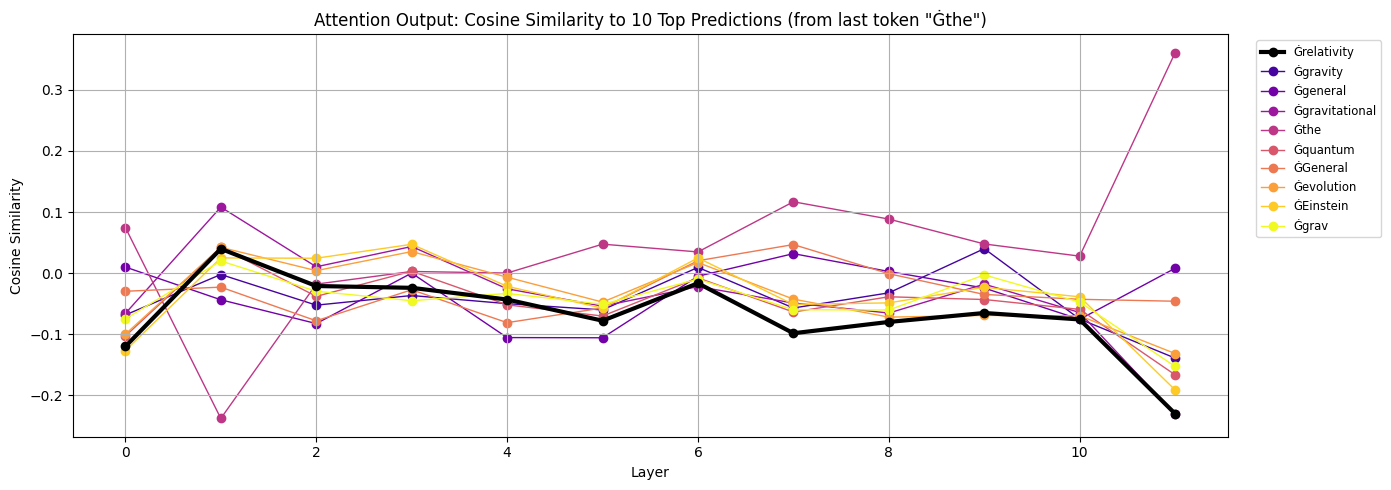

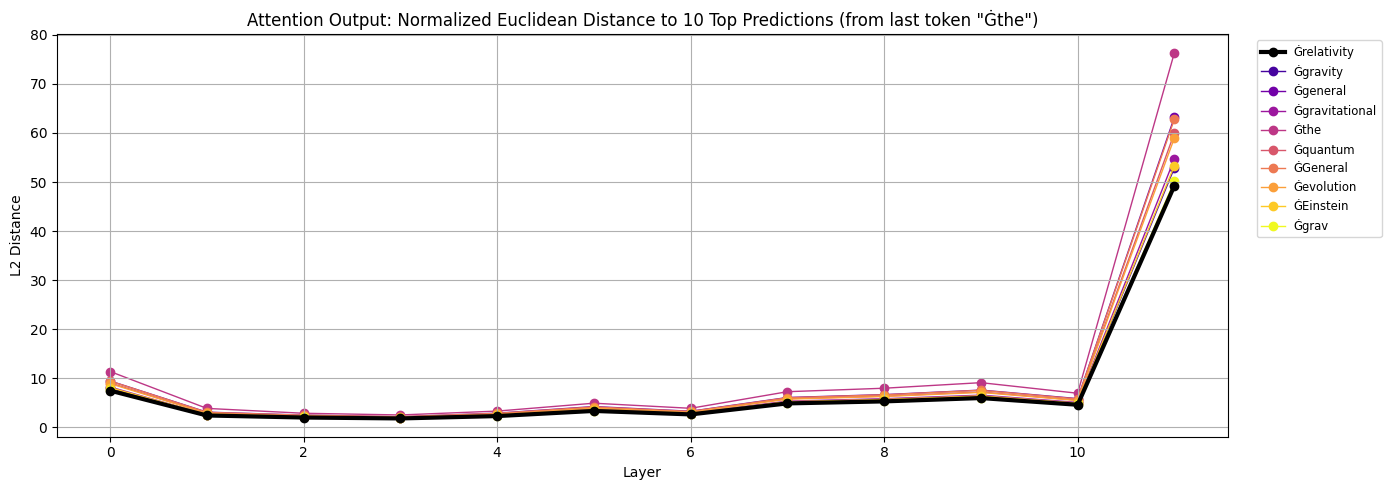

C:\Users\angel\AppData\Local\Temp\ipykernel_9644\3314977747.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", len(top_tokens))


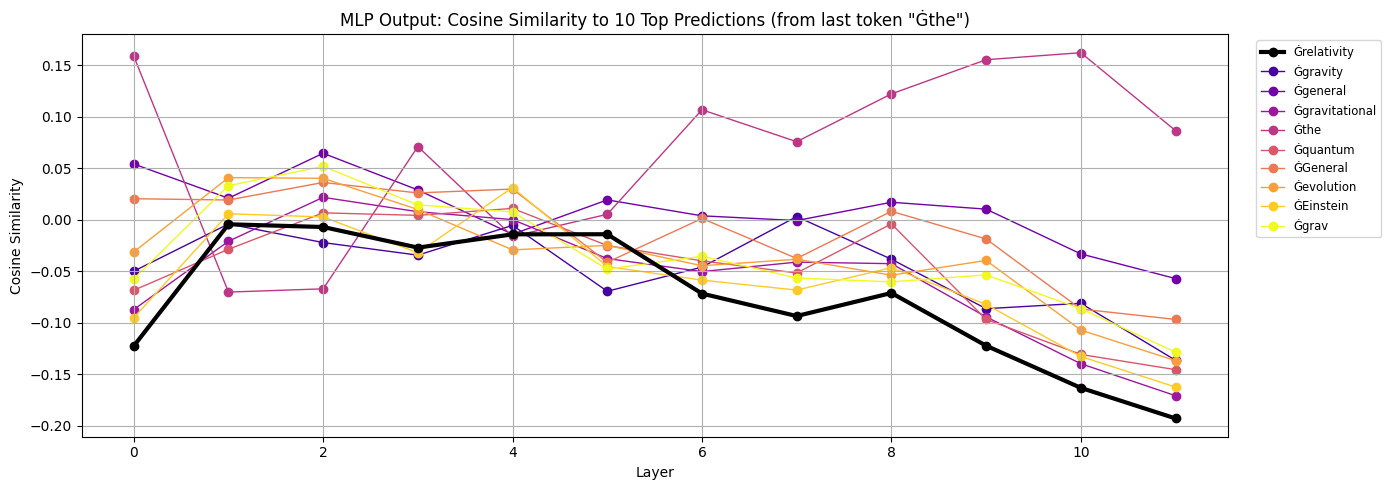

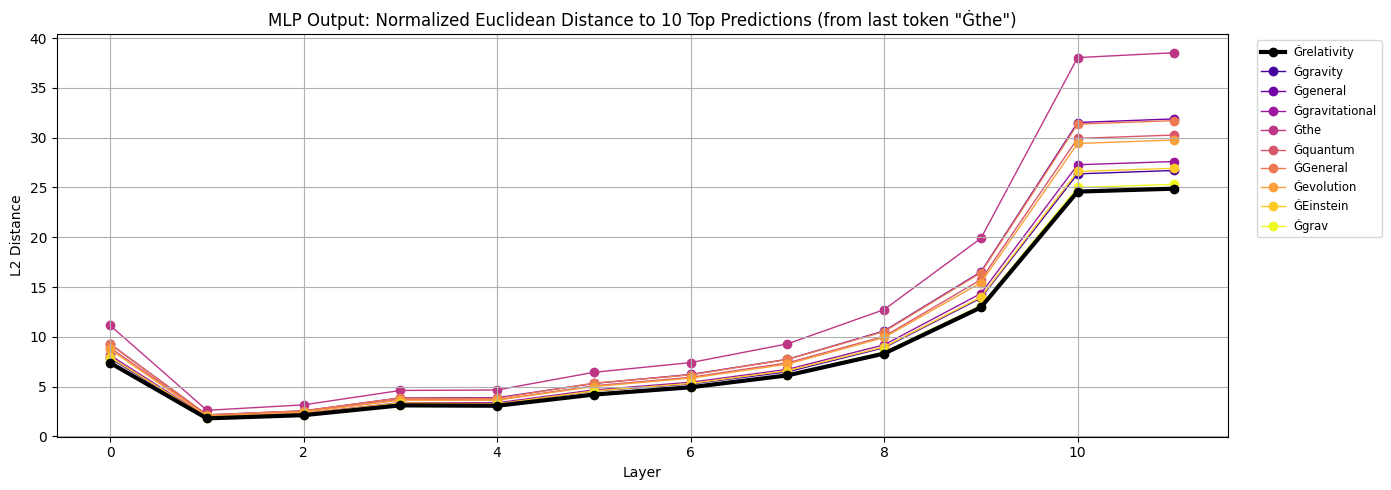

C:\Users\angel\AppData\Local\Temp\ipykernel_9644\3314977747.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", len(top_tokens))


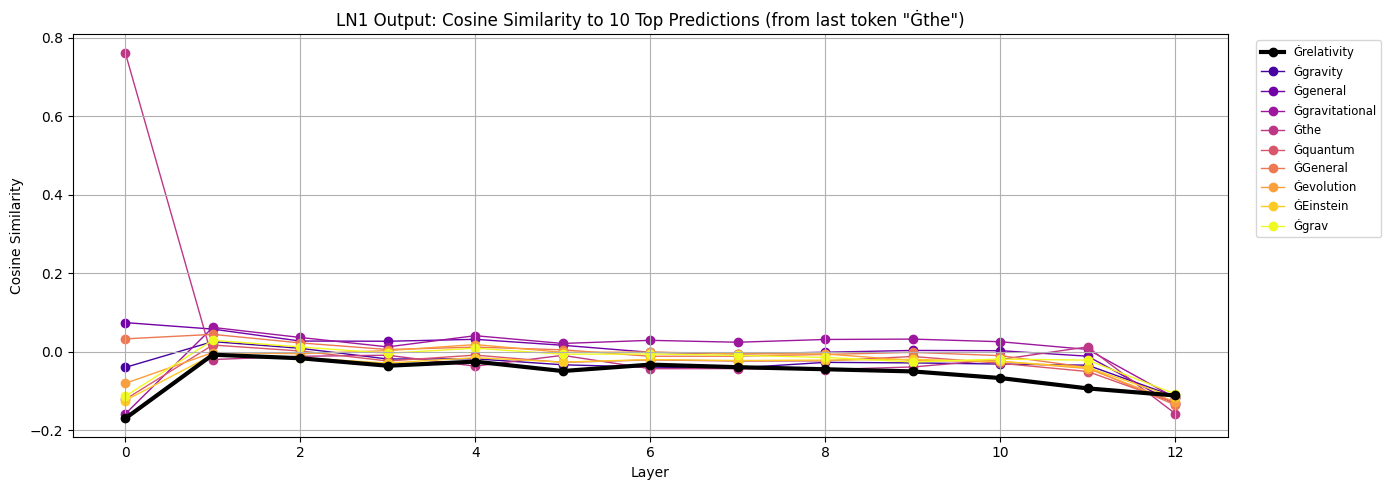

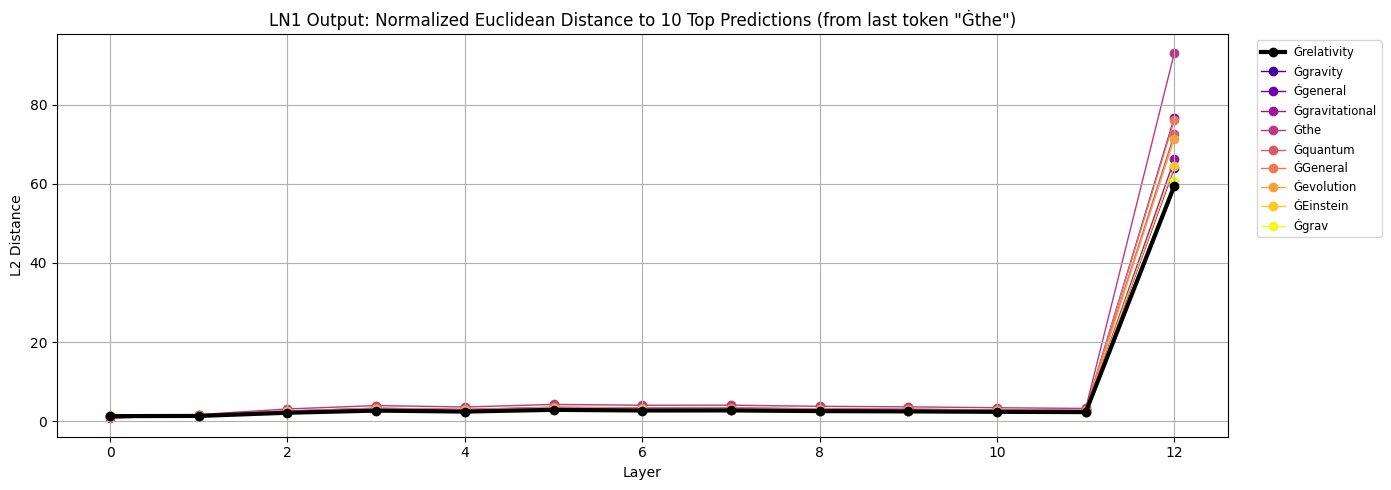

In [59]:
def compare_multiple_targets(outputs_list, target_embeds, token_position, token_label, top_tokens, label):
    n_layers = len(outputs_list)
    cos_sims_all = []
    eucl_dists_all = []
    norm_eucl_dists_all = []

    for idx, target_embed in enumerate(target_embeds):
        cos_sims = []
        eucl_dists = []
        norm_eucl_dists = []
        for layer in range(n_layers):
            vec = outputs_list[layer][0, token_position].cpu().numpy()
            cos_sims.append(cosine_similarity([vec], [target_embed])[0][0])
            eucl_dists.append(np.linalg.norm(vec - target_embed))
            norm_diff = np.linalg.norm(vec - target_embed)
            norm_base = np.linalg.norm(target_embed)
            normalized_dist = norm_diff / (norm_base + 1e-8)  # Avoid division by zero
            norm_eucl_dists.append(normalized_dist)

        cos_sims_all.append(cos_sims)
        eucl_dists_all.append(eucl_dists)
        norm_eucl_dists_all.append(norm_eucl_dists)
        

    # Prepare colors from plasma colormap
    cmap = cm.get_cmap("plasma", len(top_tokens))
    colors = [cmap(i) for i in range(len(top_tokens))]

    # Plot Cosine Similarity
    plt.figure(figsize=(14, 5))
    for i, token in enumerate(top_tokens):
        color = 'black' if i == 0 else colors[i]
        lw = 3 if i == 0 else 1
        zorder = 3 if i == 0 else 1
        plt.plot(cos_sims_all[i], label=token.strip(), color=color, linewidth=lw, marker='o', zorder=zorder)
    plt.title(f'{label}: Cosine Similarity to 10 Top Predictions (from last token "{token_label}")')
    plt.xlabel("Layer")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)
    plt.legend(fontsize='small', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


    # Plot normalized Euclidean Distance
    plt.figure(figsize=(14, 5))
    for i, token in enumerate(top_tokens):
        color = 'black' if i == 0 else colors[i]
        lw = 3 if i == 0 else 1
        zorder = 3 if i == 0 else 1
        plt.plot(norm_eucl_dists_all[i], label=token.strip(), color=color, linewidth=lw, marker='o', zorder=zorder)
    plt.title(f'{label}: Normalized Euclidean Distance to 10 Top Predictions (from last token "{token_label}")')
    plt.xlabel("Layer")
    plt.ylabel("L2 Distance")
    plt.grid(True)
    plt.legend(fontsize='small', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return cos_sims_all, eucl_dists_all, norm_eucl_dists

token_position = -1
token_label = tokens[token_position]

# Run similarity comparison
attn_cos_all, attn_dist_all, _ = compare_multiple_targets(
    attention_outputs, top_embeddings, token_position, token_label, top_tokens, "Attention Output"
)

mlp_cos_all, mlp_dist_all, _ = compare_multiple_targets(
    mlp_outputs, top_embeddings, token_position, token_label, top_tokens, "MLP Output"
)

ln_cos_all, ln_dist_all, _ = compare_multiple_targets(
    ln1_outputs, top_embeddings, token_position, token_label, top_tokens, "LN1 Output"
)


### VOLUME
To compute the volume of a polytope formed by token representations before and after the Feed-Forward Neural Network (FFNN) in a transformer model, you can approximate it using the square root of the determinant of the Gram matrix (a generalization of volume for vector sets in high dimensions).


✅ What You Need:
Hidden states before and after FFNN.


Construct the matrix 𝑉V using token vectors as rows.

Compute 
det(𝑉𝑉^𝑇)  — you might need regularization.

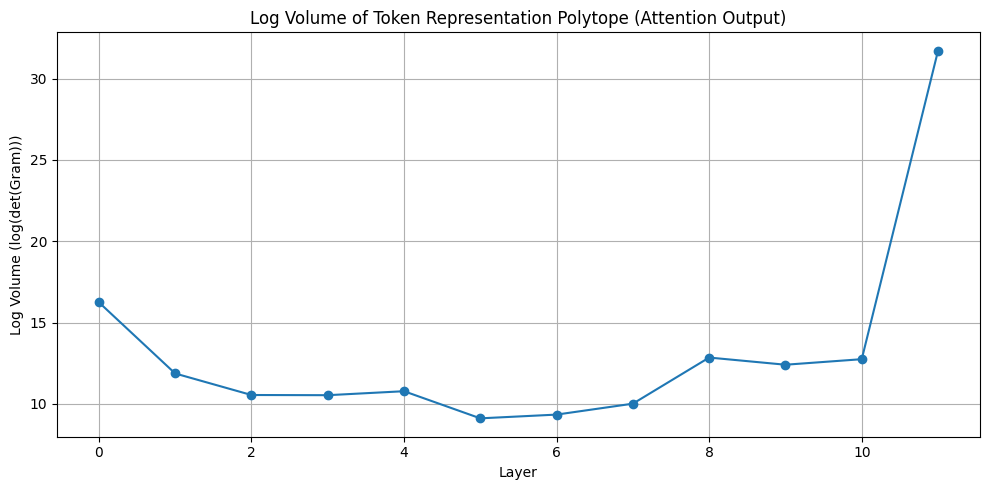

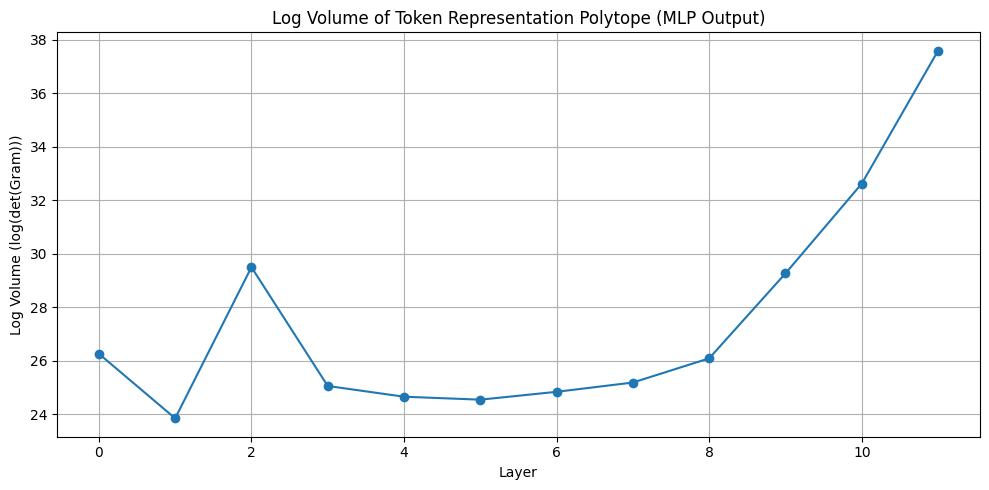

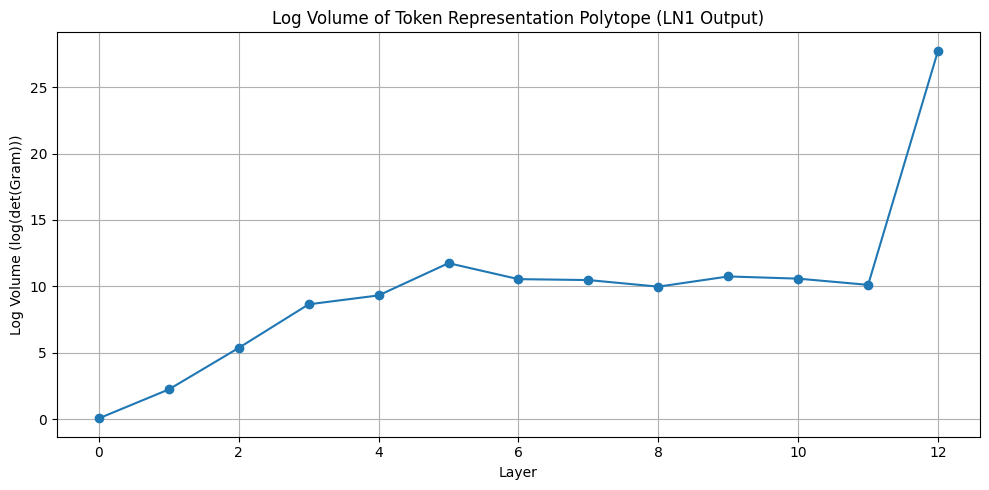

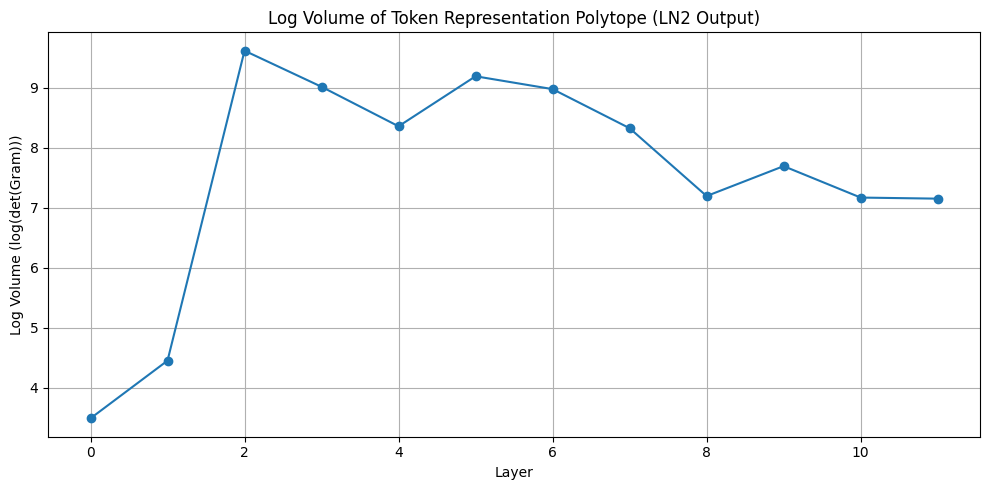

In [60]:
def compute_log_volume(outputs_list, label, epsilon=1e-6, plot_v=False):
    log_volumes = []

    for layer_idx in range(len(outputs_list)):
        layer_vecs = outputs_list[layer_idx][0]  # shape: [seq_len, hidden_dim]

        # Center the vectors
        centered = layer_vecs - layer_vecs.mean(dim=0)
        V = centered.detach().cpu().numpy()

        # Gram matrix
        G = V @ V.T  # shape: [seq_len, seq_len]

        # Stable log-determinant of Gram
        try:
            log_det = 0.5* np.linalg.slogdet(G + epsilon * np.eye(G.shape[0]))[1]
        except np.linalg.LinAlgError:
            log_det = float('-inf')

        log_volumes.append(log_det)

    # Plot
    if plot_v:
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(outputs_list)), log_volumes, marker='o')
        plt.title(f"Log Volume of Token Representation Polytope ({label})")
        plt.xlabel("Layer")
        plt.ylabel("Log Volume (log(det(Gram)))")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return log_volumes


attn_log_vols = compute_log_volume(attention_outputs, "Attention Output", plot_v=True)
mlp_log_vols = compute_log_volume(mlp_outputs, "MLP Output", plot_v=True)
ln1_log_vols = compute_log_volume(ln1_outputs, "LN1 Output", plot_v=True)
ln2_log_vols = compute_log_volume(ln2_outputs, "LN2 Output", plot_v=True)


1 13 12 12 12


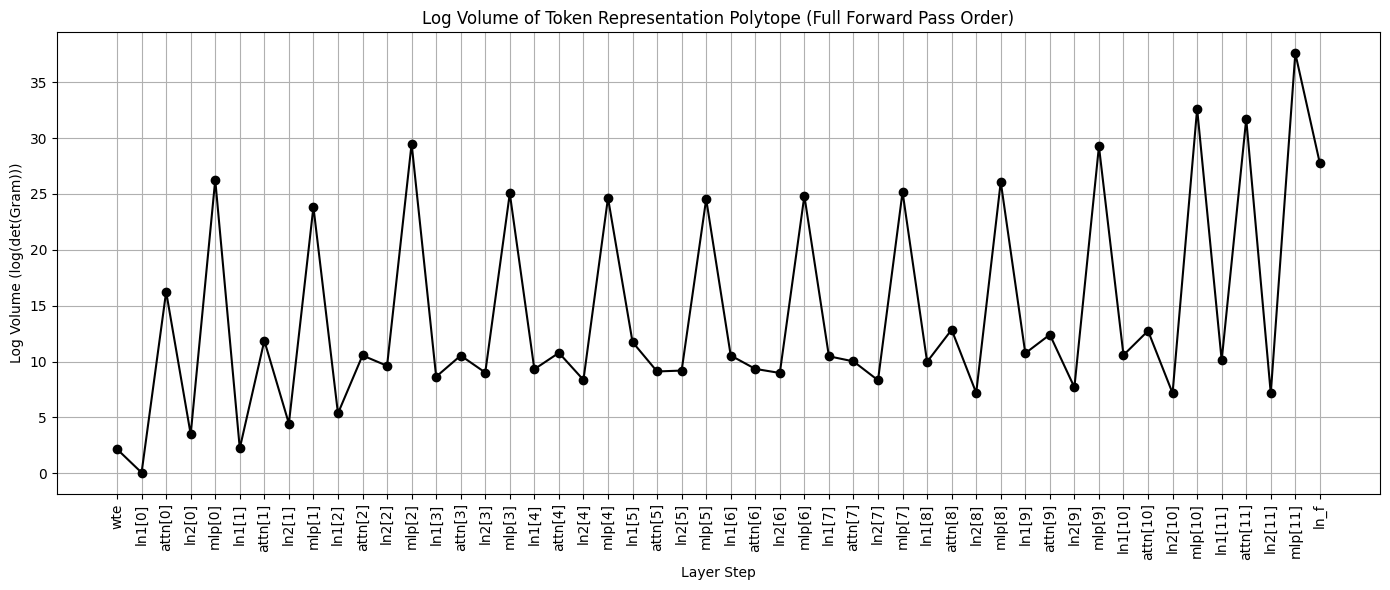

In [61]:
# Step 1: Compute all log volumes
print(len(embedding_outputs), len(ln1_outputs), len(attention_outputs), len(ln2_outputs), len(mlp_outputs))

emb_log_vols = compute_log_volume(embedding_outputs, '') # len = 2
ln1_log_vols = compute_log_volume(ln1_outputs, '')       # len = 13
attn_log_vols = compute_log_volume(attention_outputs, '')  # len = 12
ln2_log_vols = compute_log_volume(ln2_outputs, '')       # len = 12
mlp_log_vols = compute_log_volume(mlp_outputs, '')       # len = 12

# Step 2: Interleave them into a single list
all_log_vols = []
layer_labels = []
all_log_vols.append(emb_log_vols[0])
layer_labels.append('wte')
#all_log_vols.append(emb_log_vols[1])
#layer_labels.append('wpe')

for i in range(12):  # 12 layers
    all_log_vols.append(ln1_log_vols[i])
    layer_labels.append(f"ln1[{i}]")

    all_log_vols.append(attn_log_vols[i])
    layer_labels.append(f"attn[{i}]")

    all_log_vols.append(ln2_log_vols[i])
    layer_labels.append(f"ln2[{i}]")

    all_log_vols.append(mlp_log_vols[i])
    layer_labels.append(f"mlp[{i}]")

# Add final ln1[12] (ln_f)
all_log_vols.append(ln1_log_vols[12])
layer_labels.append("ln_f")

# Step 3: Plot
plt.figure(figsize=(14, 6))
plt.plot(range(len(all_log_vols)), all_log_vols, marker='o', color='black')
plt.xticks(ticks=range(len(all_log_vols)), labels=layer_labels, rotation=90)
plt.title("Log Volume of Token Representation Polytope (Full Forward Pass Order)")
plt.xlabel("Layer Step")
plt.ylabel("Log Volume (log(det(Gram)))")
plt.grid(True)
plt.tight_layout()
plt.show()


### PCA

max possible rank is $D^*=min(D, N-1)$

try the lambda vs index plot (see if there is a spectral gap -> if yes we're good, if no check the null hypothesis Marchenko Pastur Distribution)

choose d for each layer

then try to construct the cross gram matrix, svd -> get the "eigen angles" $\sigma_j$ and reconstruct the principal angle $\Theta = \sum_j cos^{-1} \sigma_j$


Application to correlation matrices
For the special case of correlation matrices, we know that 
$\sigma^2=1$ and $\lambda = \frac{m}{n}$. 

This bounds the probability mass over the interval defined by $\lambda _{\pm }=\left(1\pm {\sqrt {\frac {m}{n}}}\right)^{2}$.

Since this distribution describes the spectrum of random matrices with mean 0, the eigenvalues of correlation matrices that fall inside of the aforementioned interval could be considered spurious or noise. 

For instance, obtaining a correlation matrix of 10 stock returns calculated over a 252 trading days period would render 
$\lambda _{+}=\left(1+{\sqrt {\frac {10}{252}}}\right)^{2}\approx 1.43$. Thus, out of 10 eigenvalues of said correlation matrix, only the values higher than 1.43 would be considered significantly different from random.

In [62]:
def analyze_layer_svd_mp(activations, layer_indices=None, cumulative_threshold=0.9, title_prefix="LN1"):
    """
    Perform SVD, plot scree + cumulative variance, and compare to Marčenko–Pastur bounds for selected layers.
    
    Args:
        activations (List[Tensor]): List of layer outputs, one per layer.
        layer_indices (List[int]): Indices of layers to analyze. If None, analyze all.
        cumulative_threshold (float): Threshold for cumulative explained variance line.
        title_prefix (str): For plot titles.
    """
    if layer_indices is None:
        layer_indices = range(len(activations))

    n = len(layer_indices)
    fig, axes = plt.subplots(n, 3, figsize=(16, 4 * n), squeeze=False)

    for i, layer_idx in enumerate(layer_indices):
        X = activations[layer_idx][0].cpu().numpy()  # shape: [seq_len, hidden_dim]
        X_centered = X - X.mean(axis=0)
        U, S, VT = np.linalg.svd(X_centered, full_matrices=False)
        
        # Explained variance
        eigenvalues = (S ** 2) / X.shape[0]
        variance_ratios = eigenvalues / eigenvalues.sum()
        cumulative = np.cumsum(variance_ratios)

        # MP bounds
        n_samples, n_features = X.shape
        Q = n_samples / n_features
        sigma2 = np.var(X_centered)
        lambda_min = sigma2 * (1 - np.sqrt(1/Q))**2
        lambda_max = sigma2 * (1 + np.sqrt(1/Q))**2
        signal_count = np.sum(eigenvalues > lambda_max)

        # Scree plot
        ax1 = axes[i][0]
        ax1.plot(variance_ratios, marker='o')
        ax1.set_title(f"{title_prefix} Layer {layer_idx} - Scree")
        ax1.set_xlabel("PC Index")
        ax1.set_ylabel("Variance Ratio")
        ax1.grid(True)

        # Cumulative plot
        ax2 = axes[i][1]
        ax2.plot(cumulative, marker='o', color='green')
        ax2.axhline(y=cumulative_threshold, color='r', linestyle='--', label=f'{int(cumulative_threshold*100)}% threshold')
        ax2.set_title(f"{title_prefix} Layer {layer_idx} - Cumulative")
        ax2.set_xlabel("PC Index")
        ax2.set_ylabel("Cumulative Variance")
        ax2.set_ylim([0, 1.05])
        ax2.grid(True)
        ax2.legend()

        # Eigenvalue vs MP bounds
        ax3 = axes[i][2]
        ax3.plot(eigenvalues, marker='o', label="Eigenvalues")
        ax3.axhline(lambda_max, color='r', linestyle='--', label=f'MP Upper: {lambda_max:.4f}')
        ax3.axhline(lambda_min, color='gray', linestyle='--', label=f'MP Lower: {lambda_min:.4f}')
        ax3.set_title(f"{title_prefix} Layer {layer_idx} - MP Test\nSignal dims: {signal_count}")
        ax3.set_xlabel("Index")
        ax3.set_ylabel("Eigenvalue")
        ax3.grid(True)
        ax3.legend()

    plt.tight_layout()
    plt.show()


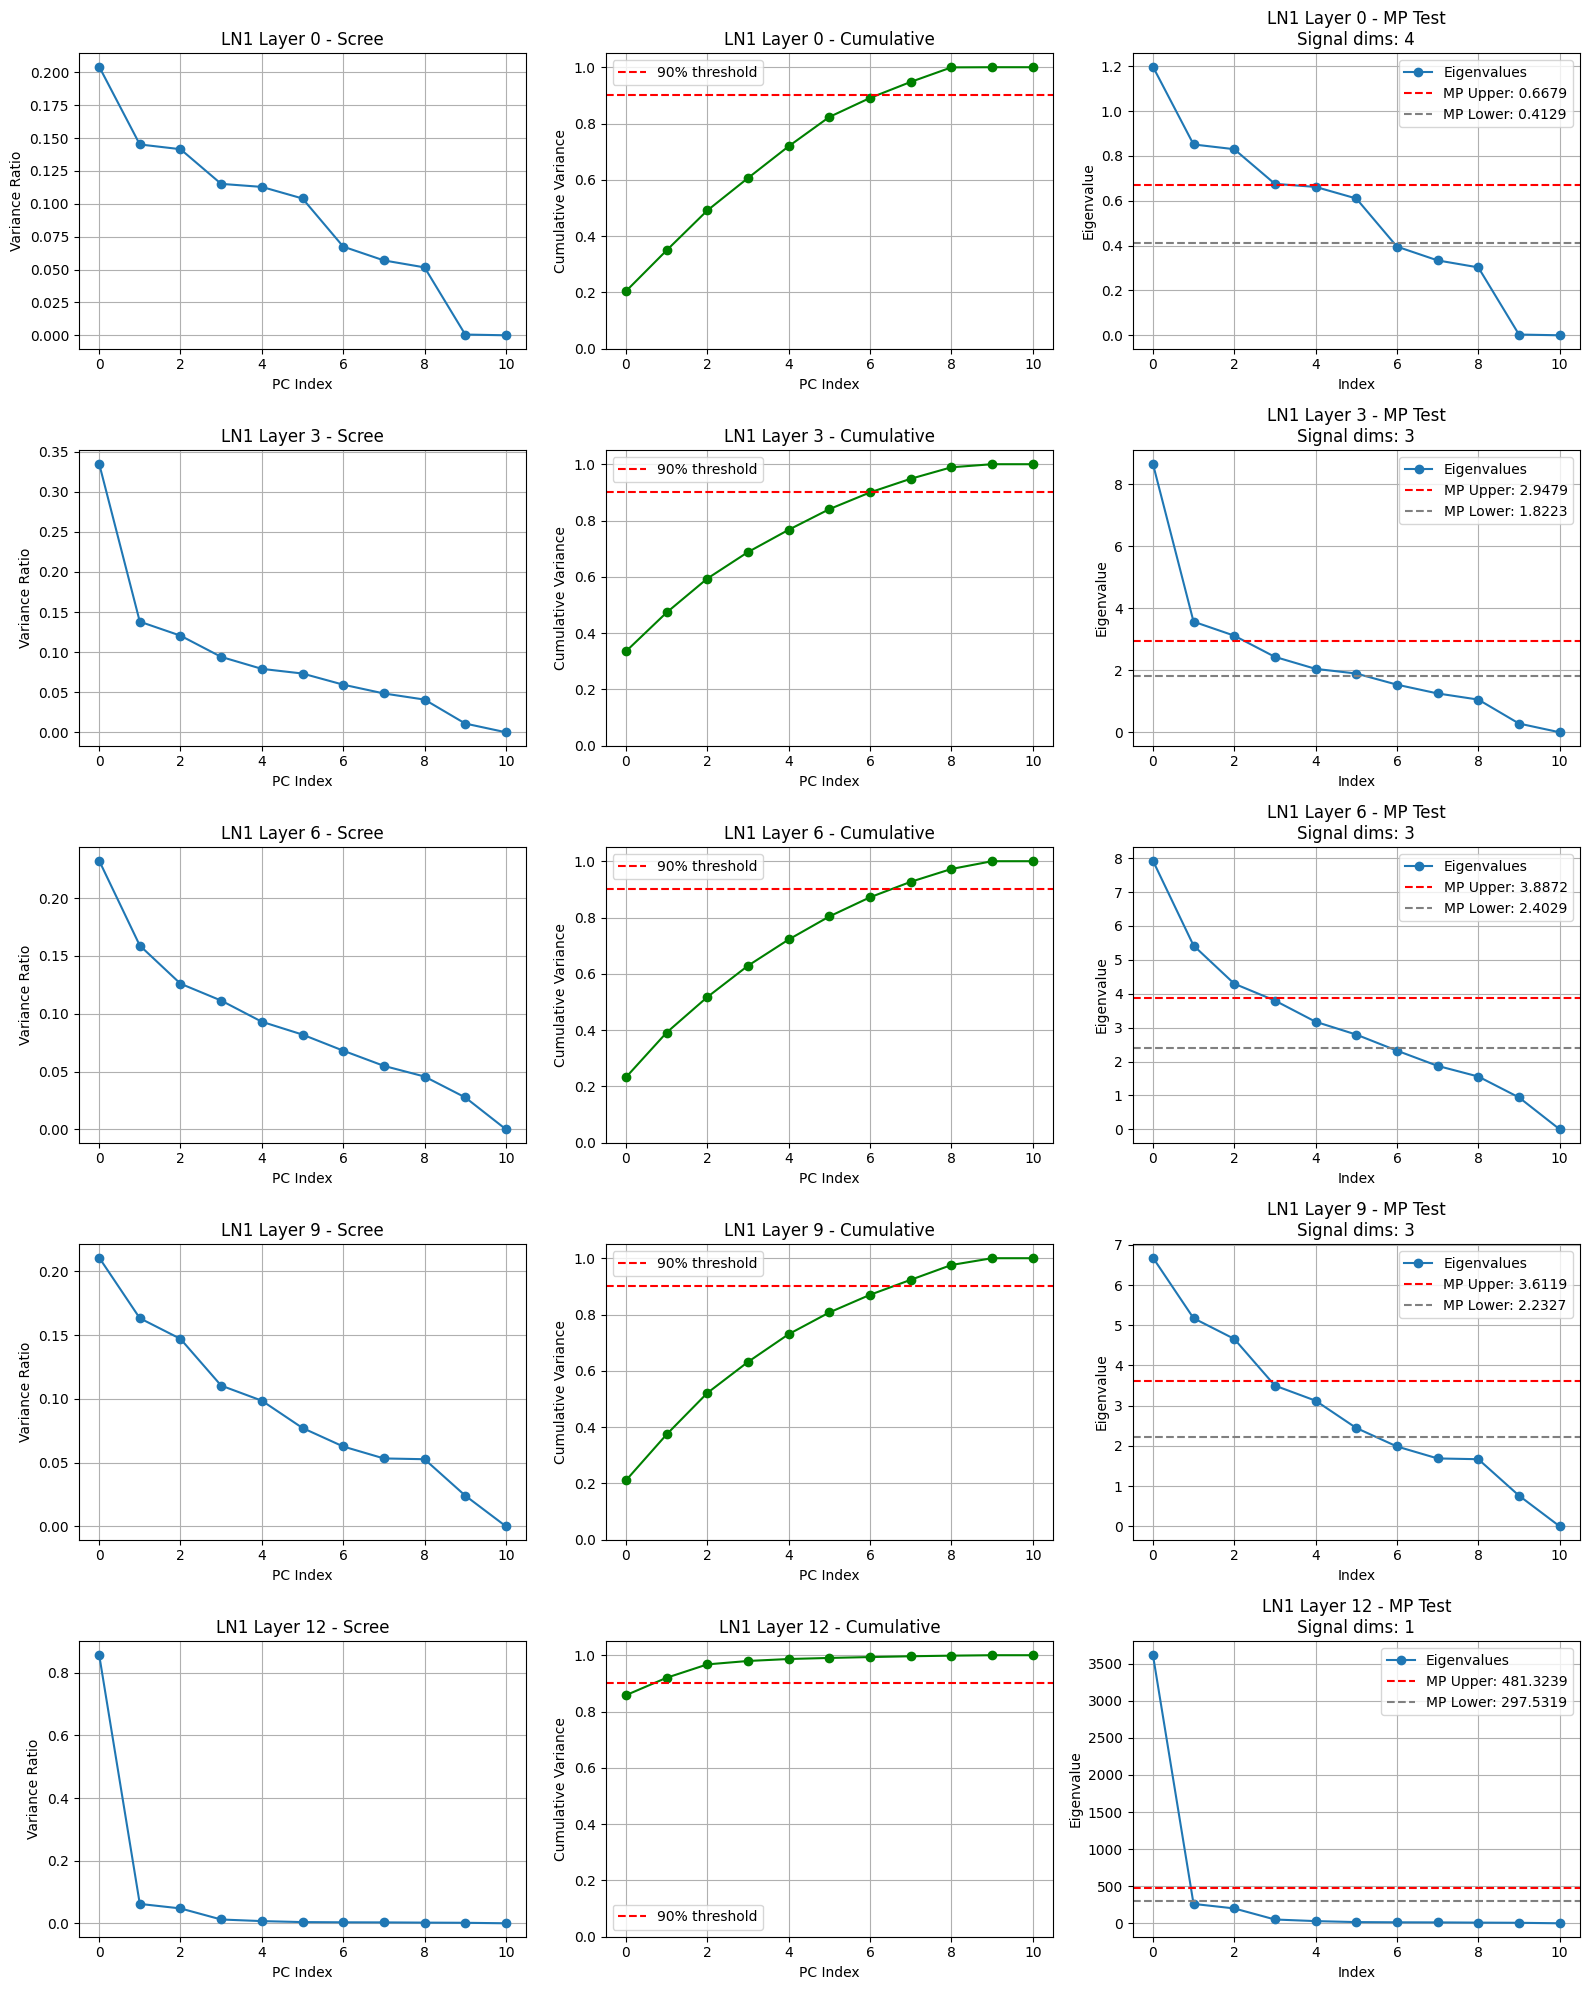

In [63]:
analyze_layer_svd_mp(ln1_outputs, layer_indices=[0, 3, 6, 9, 12], title_prefix="LN1")


In [64]:
def get_signal_dimensions(activations):
    """
    Returns a list of signal subspace dimensions per layer using MP bound.
    """
    signal_dims = []

    for layer_out in activations:
        X = layer_out[0].cpu().numpy()  # [seq_len, hidden_dim]
        X_centered = X - X.mean(axis=0)
        U, S, VT = np.linalg.svd(X_centered, full_matrices=False)
        eigenvalues = (S ** 2) / X.shape[0]

        n_samples, n_features = X.shape
        Q = n_samples / n_features
        sigma2 = np.var(X_centered)

        lambda_max = sigma2 * (1 + np.sqrt(1/Q))**2
        d = np.sum(eigenvalues > lambda_max)
        signal_dims.append(d)

    return signal_dims

def compute_principal_angles(A, B, normalize_total):
    """
    Compute the principal angles between two subspaces A and B using SVD of the cross Gram matrix.
    A, B: np.ndarray with orthonormal columns (shape: [hidden_dim, d])
    Returns:
        cosines of principal angles, angles (in radians), and sum of angles (Θ).
    """
    M = A.T @ B  # Cross Gram matrix
    U, s, Vt = np.linalg.svd(M)  # s are cos(θ_i)
    angles = np.arccos(np.clip(s, -1.0, 1.0))  # Ensure valid range
    total_angle = np.sum(angles)
    
    if normalize_total:
        max_possible_angle = len(angles) * (np.pi / 2)
        total_angle /= max_possible_angle  # Now in [0, 1]
 
    return s, angles, total_angle


In [65]:
normalized=True
# Get signal dimensions
signal_dims = get_signal_dimensions(ln1_outputs)

# Extract signal subspaces
signal_bases = []
for layer_out, d in zip(ln1_outputs, signal_dims):
    X = layer_out[0].cpu().numpy()  # [seq_len, hidden_dim]
    X_centered = X - X.mean(axis=0)
    U, _, _ = np.linalg.svd(X_centered, full_matrices=False)
    basis = U[:, :d]  # Use first d left-singular vectors
    signal_bases.append(basis)

# Compute pairwise principal angles between signal subspaces
angles_between_layers = {}
for i in range(len(signal_bases)):
    for j in range(i+1, len(signal_bases)):
        A = signal_bases[i]
        B = signal_bases[j]
        s, angles, total = compute_principal_angles(A, B, normalized)
        angles_between_layers[(i, j)] = {
            "cosines": s,
            "angles_rad": angles,
            "Θ_total": total
        }

# Optional: display example
for (i, j), angle_info in angles_between_layers.items():
    print(f"Layer {i} vs {j}:")
    print(f"  Principal angles (deg): {np.degrees(angle_info['angles_rad'])}")
    if normalized:
        print(f"  Normalized Θ : {angle_info['Θ_total']:.2f}")
    else:
        print(f"  Sum of angles Θ (deg): {np.degrees(angle_info['Θ_total']):.2f}")


Layer 0 vs 1:
  Principal angles (deg): [ 3.7858934 14.557829  20.692804  82.749176 ]
  Normalized Θ : 0.34
Layer 0 vs 2:
  Principal angles (deg): [17.09909  18.904968 81.86669 ]
  Normalized Θ : 0.44
Layer 0 vs 3:
  Principal angles (deg): [ 6.141812 17.074066 78.19359 ]
  Normalized Θ : 0.38
Layer 0 vs 4:
  Principal angles (deg): [14.042876 15.630656 80.766304]
  Normalized Θ : 0.41
Layer 0 vs 5:
  Principal angles (deg): [13.021207  14.5060835 29.514229  86.140755 ]
  Normalized Θ : 0.40
Layer 0 vs 6:
  Principal angles (deg): [18.906118 33.375988 75.29873 ]
  Normalized Θ : 0.47
Layer 0 vs 7:
  Principal angles (deg): [18.6523   31.510881 73.82859 ]
  Normalized Θ : 0.46
Layer 0 vs 8:
  Principal angles (deg): [16.139597 30.481306 77.40353 ]
  Normalized Θ : 0.46
Layer 0 vs 9:
  Principal angles (deg): [15.651164 25.233273 73.43002 ]
  Normalized Θ : 0.42
Layer 0 vs 10:
  Principal angles (deg): [ 4.9253325 17.007246  26.14744   66.621414 ]
  Normalized Θ : 0.32
Layer 0 vs 11:
  

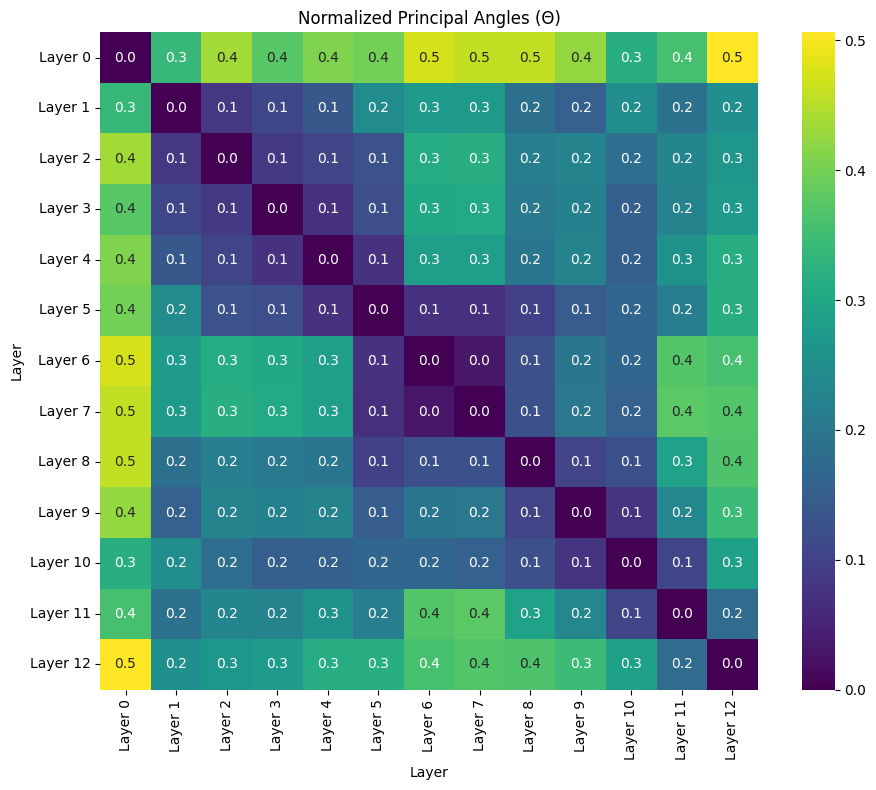

In [66]:
def plot_total_angle_heatmap(angle_dict, num_layers, normalized):
    theta_matrix = np.zeros((num_layers, num_layers))

    for (i, j), angle_info in angle_dict.items():
        if normalized:
            theta=angle_info['Θ_total']
        else:
            theta = np.degrees(angle_info["Θ_total"])  # convert to degrees
        theta_matrix[i, j] = theta
        theta_matrix[j, i] = theta  # symmetry

    plt.figure(figsize=(10, 8))
    sns.heatmap(theta_matrix, annot=True, fmt=".1f", cmap="viridis", square=True,
                xticklabels=[f"Layer {i}" for i in range(num_layers)],
                yticklabels=[f"Layer {i}" for i in range(num_layers)])
    if normalized:
        plt.title("Normalized Principal Angles (Θ)")
    else:
        plt.title("Pairwise Principal Angles (Θ)")
    plt.xlabel("Layer")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

# Run heatmap
plot_total_angle_heatmap(angles_between_layers, num_layers=len(ln1_outputs), normalized=normalized)


Principal angles measure the smallest angles between two subspaces in a vector space, quantifying how “aligned” or “different” two subspaces are. Instead of comparing single vectors (like cosine similarity), they compare sets of vectors, e.g., spaces spanned by activations of multiple tokens or multiple neurons.

Θ = 0° → identical signal subspaces.

Θ large (approaching 90° × d) → highly distinct.

Patterns in the heatmap (like blocks) can show groupings of similar layers or transitions in representation.

In [70]:
def compute_total_angle_between_outputs(out1, out2):
    """
    Compute total principal angle between two activation outputs using MP-based signal dimensions.
    """
    X1 = out1[0].cpu().numpy()
    X2 = out2[0].cpu().numpy()
    X1_centered = X1 - X1.mean(axis=0)
    X2_centered = X2 - X2.mean(axis=0)

    d1 = get_signal_dimensions([out1])[0]
    d2 = get_signal_dimensions([out2])[0]

    U1, _, _ = np.linalg.svd(X1_centered, full_matrices=False)
    U2, _, _ = np.linalg.svd(X2_centered, full_matrices=False)

    B1 = U1[:, :d1]
    B2 = U2[:, :d2]

    _, _, total_angle = compute_principal_angles(B1, B2, False)
    return np.degrees(total_angle)


In [71]:
all_outputs = []
all_labels = []

for i in range(12):
    all_outputs.extend([ln1_outputs[i], attention_outputs[i], ln2_outputs[i], mlp_outputs[i]])
    all_labels.extend([f"ln1[{i}]", f"attn[{i}]", f"ln2[{i}]", f"mlp[{i}]"])

# Add final layer norm
all_outputs.append(ln1_outputs[12])
all_labels.append("ln_f")


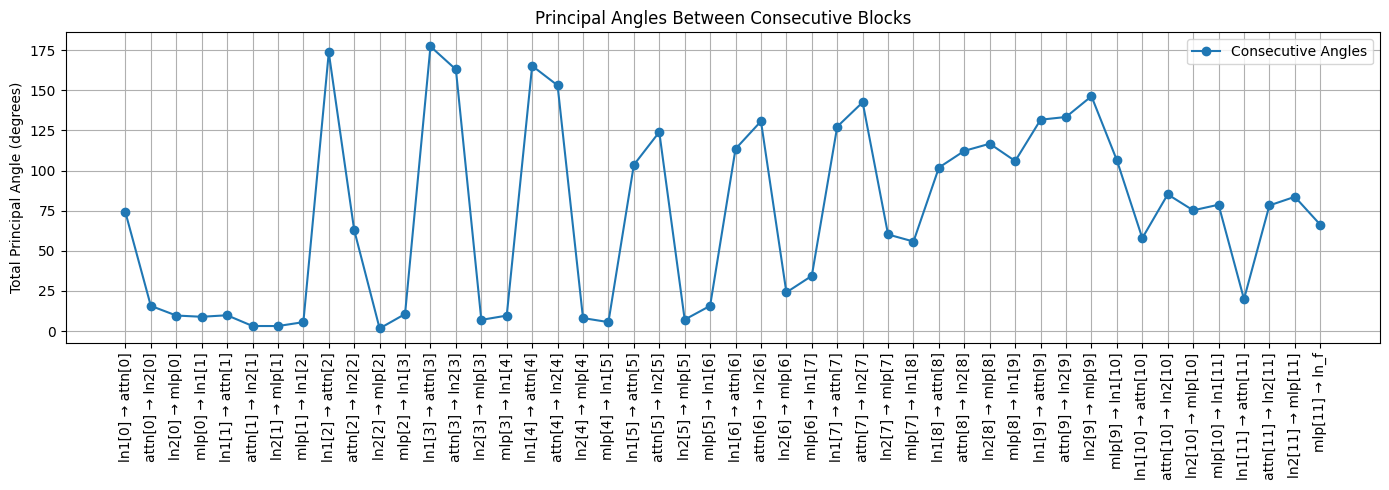

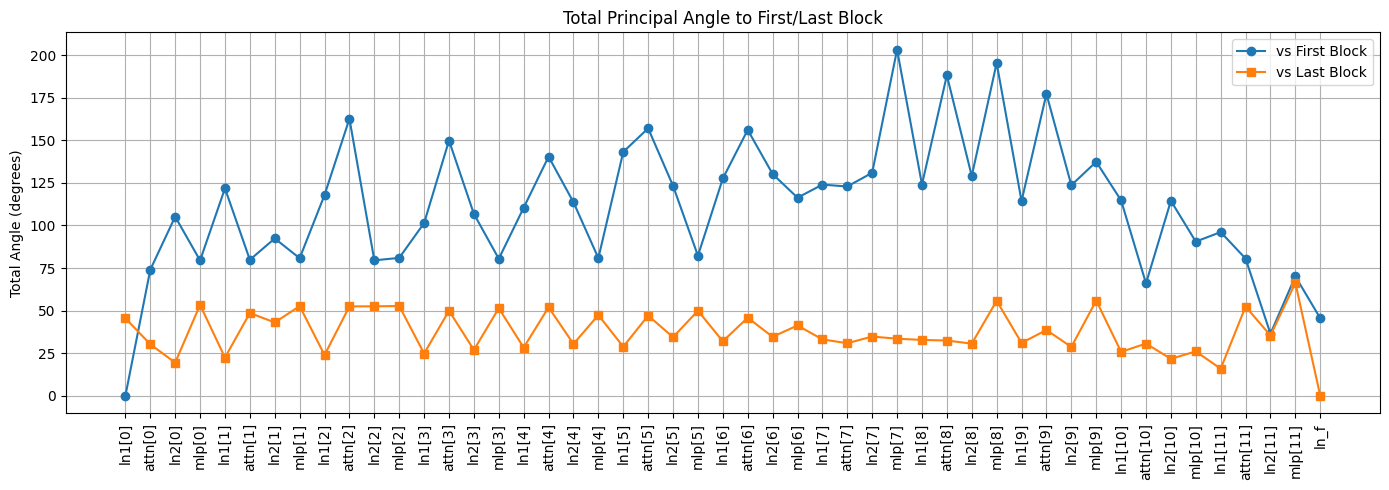

In [72]:
consecutive_angles = [
    compute_total_angle_between_outputs(all_outputs[i], all_outputs[i+1])
    for i in range(len(all_outputs) - 1)
]

angles_vs_first = [
    compute_total_angle_between_outputs(all_outputs[0], out)
    for out in all_outputs
]

angles_vs_last = [
    compute_total_angle_between_outputs(all_outputs[-1], out)
    for out in all_outputs
]
plt.figure(figsize=(14, 5))
plt.plot(consecutive_angles, marker='o', label="Consecutive Angles")
plt.xticks(ticks=range(len(all_labels)-1), labels=[f"{all_labels[i]} → {all_labels[i+1]}" for i in range(len(all_labels)-1)], rotation=90)
plt.title("Principal Angles Between Consecutive Blocks")
plt.ylabel("Total Principal Angle (degrees)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(angles_vs_first, label="vs First Block", marker='o')
plt.plot(angles_vs_last, label="vs Last Block", marker='s')
plt.xticks(ticks=range(len(all_labels)), labels=all_labels, rotation=90)
plt.title("Total Principal Angle to First/Last Block")
plt.ylabel("Total Angle (degrees)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [73]:
# Convert top_embeddings to tensor and add batch dim (batch=1)
target_tensor = torch.tensor(top_embeddings[:-1]).unsqueeze(0)  # shape (1, num_top_tokens, embedding_dim)

# Assuming you want to compare for attention_outputs (list of tensors)

angles_per_layer = [
    compute_total_angle_between_outputs(target_tensor, out)
    for out in all_outputs
]

'''
for layer_out in attention_outputs:
    # layer_out shape: (1, seq_len, hidden_dim)
    angle_deg = compute_total_angle_between_outputs([layer_out], [target_tensor])
    angles_per_layer.append(angle_deg)
    '''

# Now angles_per_layer contains principal angles (degrees) between target embedding subspace and each layer's output subspace

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(range(len(angles_per_layer)), angles_per_layer, marker='o')
plt.xlabel("Layer")
plt.ylabel("Principal angle (degrees)")
plt.xticks(ticks=range(len(all_labels)), labels=all_labels, rotation=90)
plt.title("Principal angle between target embeddings and attention outputs per layer")
plt.grid(True)
plt.show()


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 11 is different from 9)

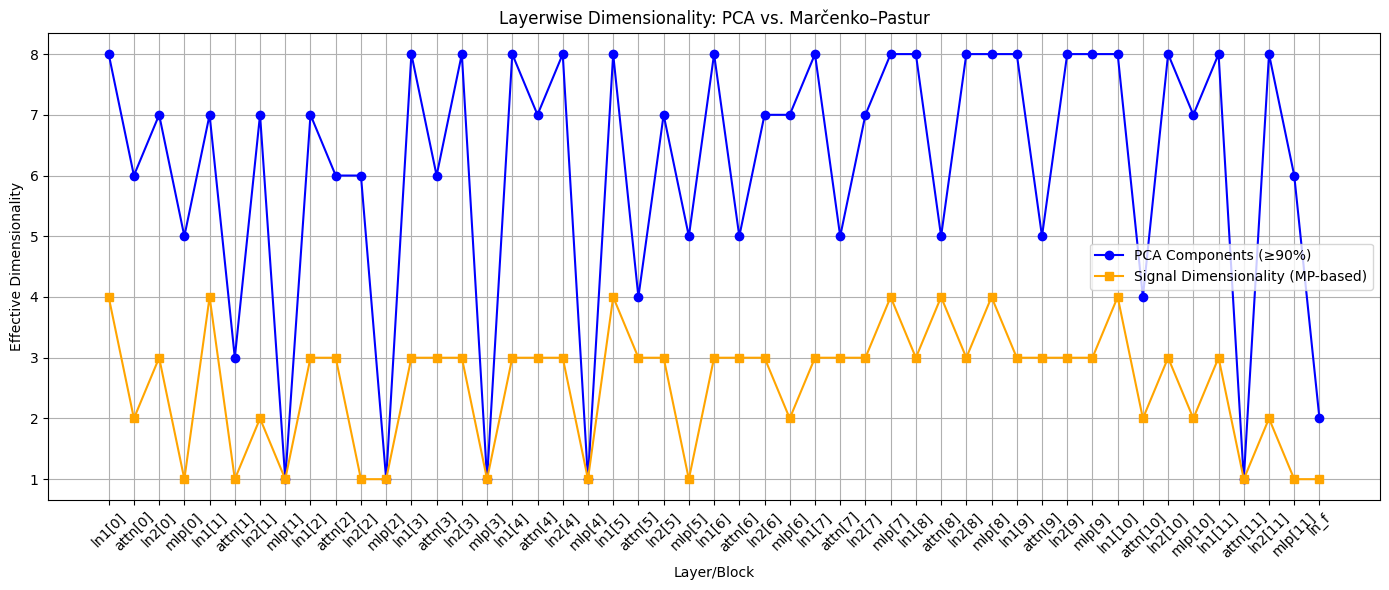

In [75]:
def compute_pca_components(outputs_list, cumulative_threshold=0.9):
    component_counts = []

    for out in outputs_list:
        vecs = out[0].cpu().numpy()  # shape: [seq_len, hidden_dim]
        pca = PCA()
        pca.fit(vecs)
        explained = pca.explained_variance_ratio_
        cumulative = np.cumsum(explained)
        num_components = np.searchsorted(cumulative, cumulative_threshold) + 1
        component_counts.append(num_components)

    return component_counts

# First, compute PCA-based dimensionalities
pca_ln1 = compute_pca_components(ln1_outputs)
pca_attn = compute_pca_components(attention_outputs)
pca_ln2 = compute_pca_components(ln2_outputs)
pca_mlp = compute_pca_components(mlp_outputs)

# Now compute signal dimensionalities using the same function across blocks
signal_ln1 = get_signal_dimensions(ln1_outputs)
signal_attn = get_signal_dimensions(attention_outputs)
signal_ln2 = get_signal_dimensions(ln2_outputs)
signal_mlp = get_signal_dimensions(mlp_outputs)

# Interleave values across blocks for visualization
pca_dims_all = []
signal_dims_all = []
labels = []

for i in range(12):
    pca_dims_all.append(pca_ln1[i])
    signal_dims_all.append(signal_ln1[i])
    labels.append(f"ln1[{i}]")

    pca_dims_all.append(pca_attn[i])
    signal_dims_all.append(signal_attn[i])
    labels.append(f"attn[{i}]")

    pca_dims_all.append(pca_ln2[i])
    signal_dims_all.append(signal_ln2[i])
    labels.append(f"ln2[{i}]")

    pca_dims_all.append(pca_mlp[i])
    signal_dims_all.append(signal_mlp[i])
    labels.append(f"mlp[{i}]")

# Add ln_f
pca_dims_all.append(pca_ln1[12])
signal_dims_all.append(signal_ln1[12])
labels.append("ln_f")

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(pca_dims_all, marker='o', label='PCA Components (≥90%)', color='blue')
plt.plot(signal_dims_all, marker='s', label='Signal Dimensionality (MP-based)', color='orange')

plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
plt.title("Layerwise Dimensionality: PCA vs. Marčenko–Pastur")
plt.xlabel("Layer/Block")
plt.ylabel("Effective Dimensionality")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Inspection of the space

✅ Goal: Measure the "Exploration of Subspace"
This typically means:

How diverse are the signal subspaces over time (or over data)?

How much of the ambient space is explored?

In linear algebra terms: how much of the total high-dimensional space is spanned by the collection of signal subspaces?

✅ Approaches You Can Take
1. Union Subspace Rank (Dimensionality of Combined Subspace)

In [76]:
def compute_union_subspace_rank(signal_bases, tol=1e-6):
    all_bases = np.concatenate(signal_bases, axis=1)  # [hidden_dim, total_d]
    u, s, _ = np.linalg.svd(all_bases, full_matrices=False)
    rank = np.sum(s > tol)
    return rank, s


2. Volume of the Grassmannian Convex Hull (Rough Proxy)
Compute the mean pairwise principal angles or the total volume subtended by multiple subspaces. While true Grassmannian volumes are complex to compute, you can approximate "spread" via average orthogonality.

For example:
Higher avg_angle → subspaces are more diverse → space is more explored.

In [77]:
def compute_angle_statistics(angles_between_layers, in_degrees=False):
    all_angles = [info["Θ_total"] for info in angles_between_layers.values()]
    if in_degrees:
        all_angles = [np.degrees(a) for a in all_angles]
    avg_angle = np.mean(all_angles)
    max_angle = np.max(all_angles)
    min_angle = np.min(all_angles)
    return {
        "mean_angle": avg_angle,
        "max_angle": max_angle,
        "min_angle": min_angle,
        "num_pairs": len(all_angles)
    }


In [78]:
def plot_consecutive_layer_angles(signal_bases):
    consecutive_angles = []
    for i in range(len(signal_bases) - 1):
        _, _, theta = compute_principal_angles(signal_bases[i], signal_bases[i+1], normalize_total=False)
        consecutive_angles.append(np.degrees(theta))

    plt.plot(consecutive_angles, marker='o', color='tab:blue')
    plt.title("Consecutive Layer Subspace Angles (Θ)")
    plt.xlabel("Layer Index")
    plt.ylabel("Angle (degrees)")
    plt.grid(True)
    plt.show()


In [79]:
def plot_union_rank(rank, hidden_dim):
    plt.bar(["Explored Rank"], [rank], color='tab:green')
    plt.axhline(hidden_dim, linestyle="--", color="gray", label="Max Dim")
    plt.title("Union Subspace Dimensionality")
    plt.ylabel("Dimension")
    plt.legend()
    plt.ylim(0, hidden_dim + 5)
    plt.grid(True, axis='y')
    plt.show()


3. Subspace Dispersion Metric
Construct a dispersion metric like:

dispersion
=
2
𝑛
(
𝑛
−
1
)
∑
𝑖
<
𝑗
Θ
𝑖
,
𝑗
dispersion= 
n(n−1)
2
​
  
i<j
∑
​
 Θ 
i,j
​
 
Where 
Θ
𝑖
,
𝑗
Θ 
i,j
​
  is the total principal angle (in radians or degrees).



In [80]:
from sklearn.manifold import MDS

def plot_mds_embedding(angles_between_layers, num_layers):
    dist_matrix = np.zeros((num_layers, num_layers))
    for (i, j), info in angles_between_layers.items():
        dist_matrix[i, j] = info["Θ_total"]
        dist_matrix[j, i] = info["Θ_total"]  # symmetric

    mds = MDS(dissimilarity="precomputed", random_state=42)
    coords = mds.fit_transform(dist_matrix)

    plt.scatter(coords[:, 0], coords[:, 1], c=range(num_layers), cmap='viridis', s=60)
    for i in range(num_layers):
        plt.text(coords[i, 0], coords[i, 1], f"L{i}", fontsize=9)
    plt.title("MDS Embedding of Subspace Geometry")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.colorbar(label="Layer Index")
    plt.grid(True)
    plt.show()


### dispersion_score (Average normalized angle)

This is similar to avg_pairwise_angle, but using normalized total angles (from compute_principal_angles(..., normalize_total=True)).

You need a second dictionary with normalized Θ values — here's how:

Add this before your metric computations:

In [81]:
# Build normalized angle dictionary
normalized_angles_between_layers = {}
for i in range(len(signal_bases)):
    for j in range(i + 1, len(signal_bases)):
        A = signal_bases[i]
        B = signal_bases[j]
        _, _, total = compute_principal_angles(A, B, normalize_total=True)
        normalized_angles_between_layers[(i, j)] = {"Θ_total": total}

def compute_dispersion_score(normalized_angle_dict):
    scores = [info["Θ_total"] for info in normalized_angle_dict.values()]
    return np.mean(scores)

dispersion_score = compute_dispersion_score(normalized_angles_between_layers)
print(f"Dispersion score (normalized Θ): {dispersion_score:.3f}")


Dispersion score (normalized Θ): 0.237


The dispersion score is the average normalized total principal angle between all pairs of subspaces:

It ranges from 0 to 1:

0 = all subspaces are identical (no dispersion).

1 = all subspaces are maximally disjoint (orthogonal, completely different directions).

It reflects how spread out or diverse the set of subspaces is in the high-dimensional space.

Think of each layer’s subspace as a camera angle on a scene. The dispersion score tells you whether they’re all pointing in the same direction (low dispersion) or completely different directions (high dispersion).

In a buffer (e.g., memory or sequence model), a higher dispersion score implies:
The system explores a wider range of directions over time.
Likely retains less redundancy.
Can encode more information or capture temporal variation.

A low dispersion score suggests:
Redundant representations across layers.
Possibly more stability, but less flexibility.

✅ 4. subspace_overlap

Define overlap as: Fraction of shared signal directions between layer i and layer j.

In [82]:
def compute_subspace_overlap(A, B, threshold=0.9):
    """
    A, B: [hidden_dim, d] orthonormal bases.
    Return: fraction of principal angles below threshold (in cosine similarity).
    """
    s, _, _ = compute_principal_angles(A, B, normalize_total=False)
    return np.mean(s > threshold)  # higher = more overlap


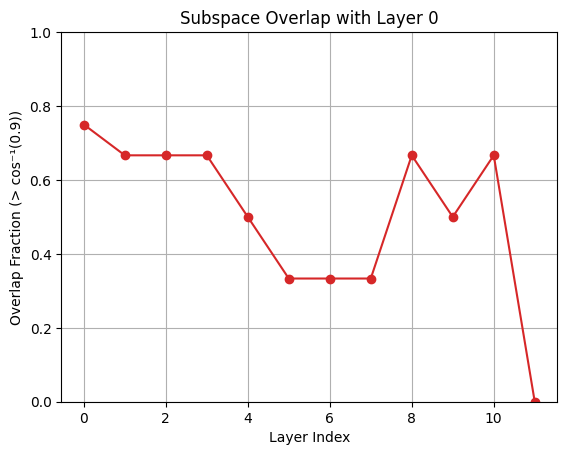

In [83]:
overlaps_with_first = [compute_subspace_overlap(signal_bases[0], signal_bases[i])
                       for i in range(1, len(signal_bases))]

plt.plot(overlaps_with_first, marker='o', color='tab:red')
plt.title("Subspace Overlap with Layer 0")
plt.xlabel("Layer Index")
plt.ylabel("Overlap Fraction (> cos⁻¹(0.9))")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


This tells you how much each later layer still shares the directions of earlier ones, which is a good proxy for "memory" or "repetition."

Avg Principal Angle (Θ): 13.58°
Max Angle: 29.00°
Min Angle: 1.79°
Num Layer Pairs: 78


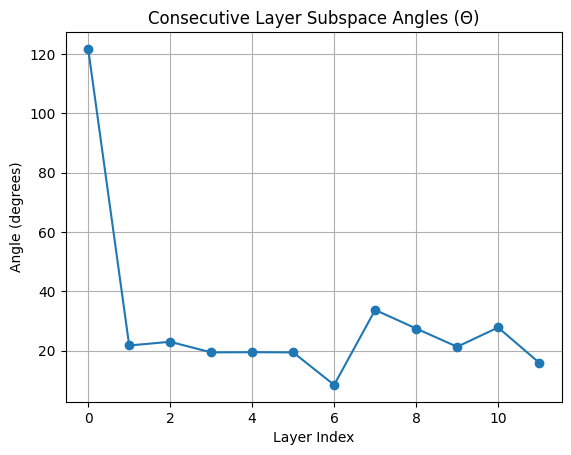

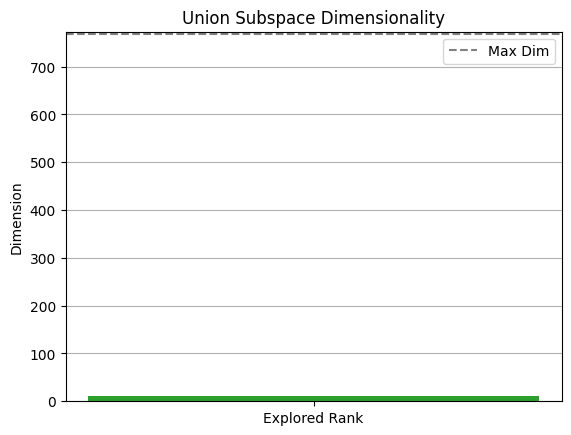

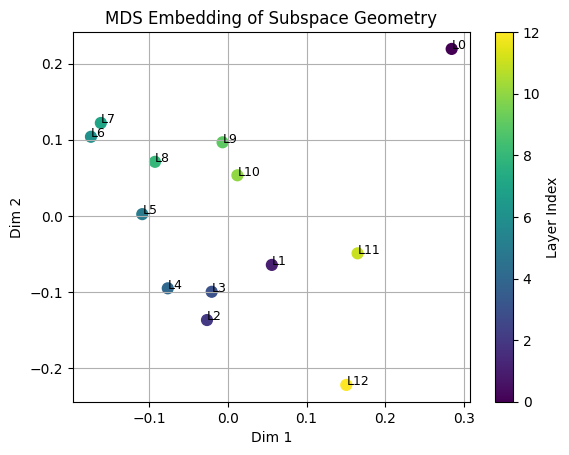

In [84]:
# --- Compute rank of total explored space
hidden_dim = ln1_outputs[0][0].shape[1]
union_rank, _ = compute_union_subspace_rank(signal_bases)

# --- Angle statistics
angle_stats = compute_angle_statistics(angles_between_layers, in_degrees=True)
print(f"Avg Principal Angle (Θ): {angle_stats['mean_angle']:.2f}°")
print(f"Max Angle: {angle_stats['max_angle']:.2f}°")
print(f"Min Angle: {angle_stats['min_angle']:.2f}°")
print(f"Num Layer Pairs: {angle_stats['num_pairs']}")

# --- Visualizations
plot_consecutive_layer_angles(signal_bases)
plot_union_rank(union_rank, hidden_dim)
plot_mds_embedding(angles_between_layers, num_layers=len(signal_bases))


MDS (Multidimensional Scaling) is a technique that projects high-dimensional objects (like subspaces) into 2D or 3D, while preserving the pairwise distances between them as faithfully as possible.

In your case:

You computed pairwise total principal angles Θ between each pair of layer subspaces.

You treat those angles as distances (more angle = more dissimilarity).

MDS places each subspace as a point in 2D, such that their Euclidean distance ≈ subspace angle.

🔍 What Does the MDS Plot Show?
Each point represents a layer's subspace.

Points close together → layers have very similar signal directions (high overlap).

Points far apart → layers span different parts of the space (low overlap, high dispersion).

Spread of the points shows how much the buffer "moves" through signal space.

🧠 Think of it Like:
You're mapping the trajectory of the buffer through high-dimensional representation space, and MDS gives you a 2D bird’s-eye view of that journey.

| MDS Pattern            | What It Suggests                                           |
| ---------------------- | ---------------------------------------------------------- |
| **Tight cluster**      | Layers are similar — redundancy or stable representations. |
| **Linear trail / arc** | Smooth, progressive change — like a temporal evolution.    |
| **Scattered spread**   | Highly dynamic changes across layers — strong diversity.   |
| **Loops / cycles**     | Possible recurrence, memory reuse, or oscillations.        |


### Summary Metric to Report
Here’s what you can report as “buffer exploration”:

Metric	Description
effective_rank	Number of unique directions spanned by all signal subspaces.
avg_pairwise_angle	Mean total angle between all pairs — higher = more diverse.
dispersion_score	Average normalized angle between all layer pairs.
subspace_overlap	Optionally, you can compute how much overlap there is with earlier layers.


### Summary of Visualizations
Visualization	Purpose
Heatmap (pairwise Θ)	Local similarity across layers
Line plot (Θ across time)	Change across buffer/layers
Bar plot (rank of union)	Total space explored
2D embedding (MDS/t-SNE)	Geometric diversity of subspaces
Entropy of projections	Distributional variety in directions